In this notebook I am analysing House Prices data to predict the price of house. 
So this notebook contains the following in the mentioned order:
* Used heatmap to look for correlation of variables with all the other variables and looked for those that seemed important.   Reference: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python 
* Then correct the data for missing values and outliers.
* Used Linear regression model to predict the price.
* Also used Random Forest and see which one perform better.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.model_selection import train_test_split
from pandas import Series

In [2]:
data= r'C:\Users\bhardwaj\Downloads\house-prices-advanced-regression-techniques\train.csv'

In [3]:
df=pd.read_csv(data)

In [4]:
df=df.set_index('Id') #Setting ID as index of the data.

In [5]:
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


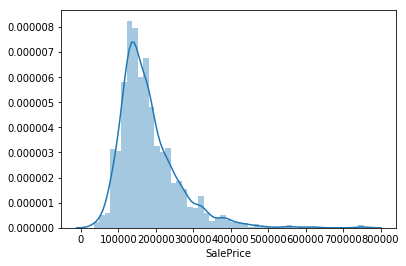

In [6]:
sns.distplot(df['SalePrice'])

The distribution of SalePrice shows following properties:
* Skewed to the right and not a normal distribution. 
* Also it has peakedness.

In [7]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


###### Below is the heatmap which shows correlation among variables in the data.

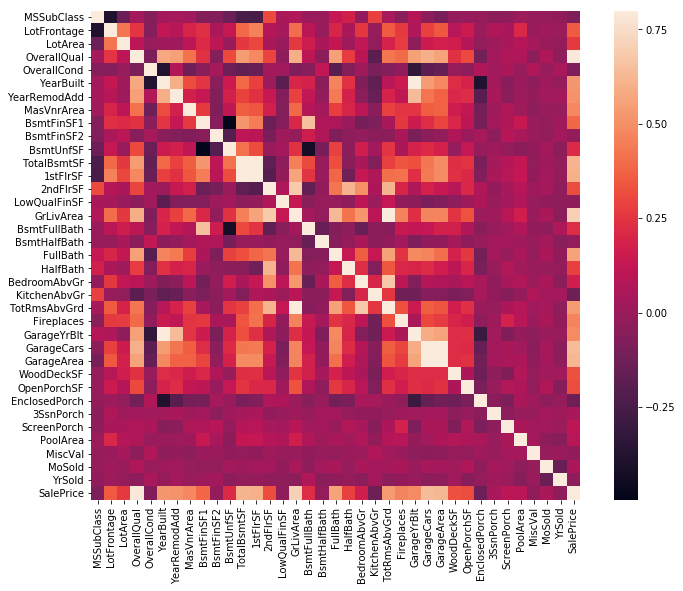

In [8]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Above, OverallQual, GrLivArea, YearBuilt, YearRemodAdd, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd, GarageCars,GarageArea shows high correlation with Sale price.

In [9]:
cols=df[['OverallQual','GrLivArea', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea','SalePrice']]

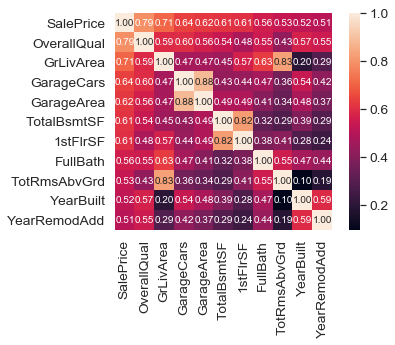

In [10]:
cols = corrmat.nlargest(11, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Top 11 largest correlated variables with SalePrice. 

C:\Users\bhardwaj\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


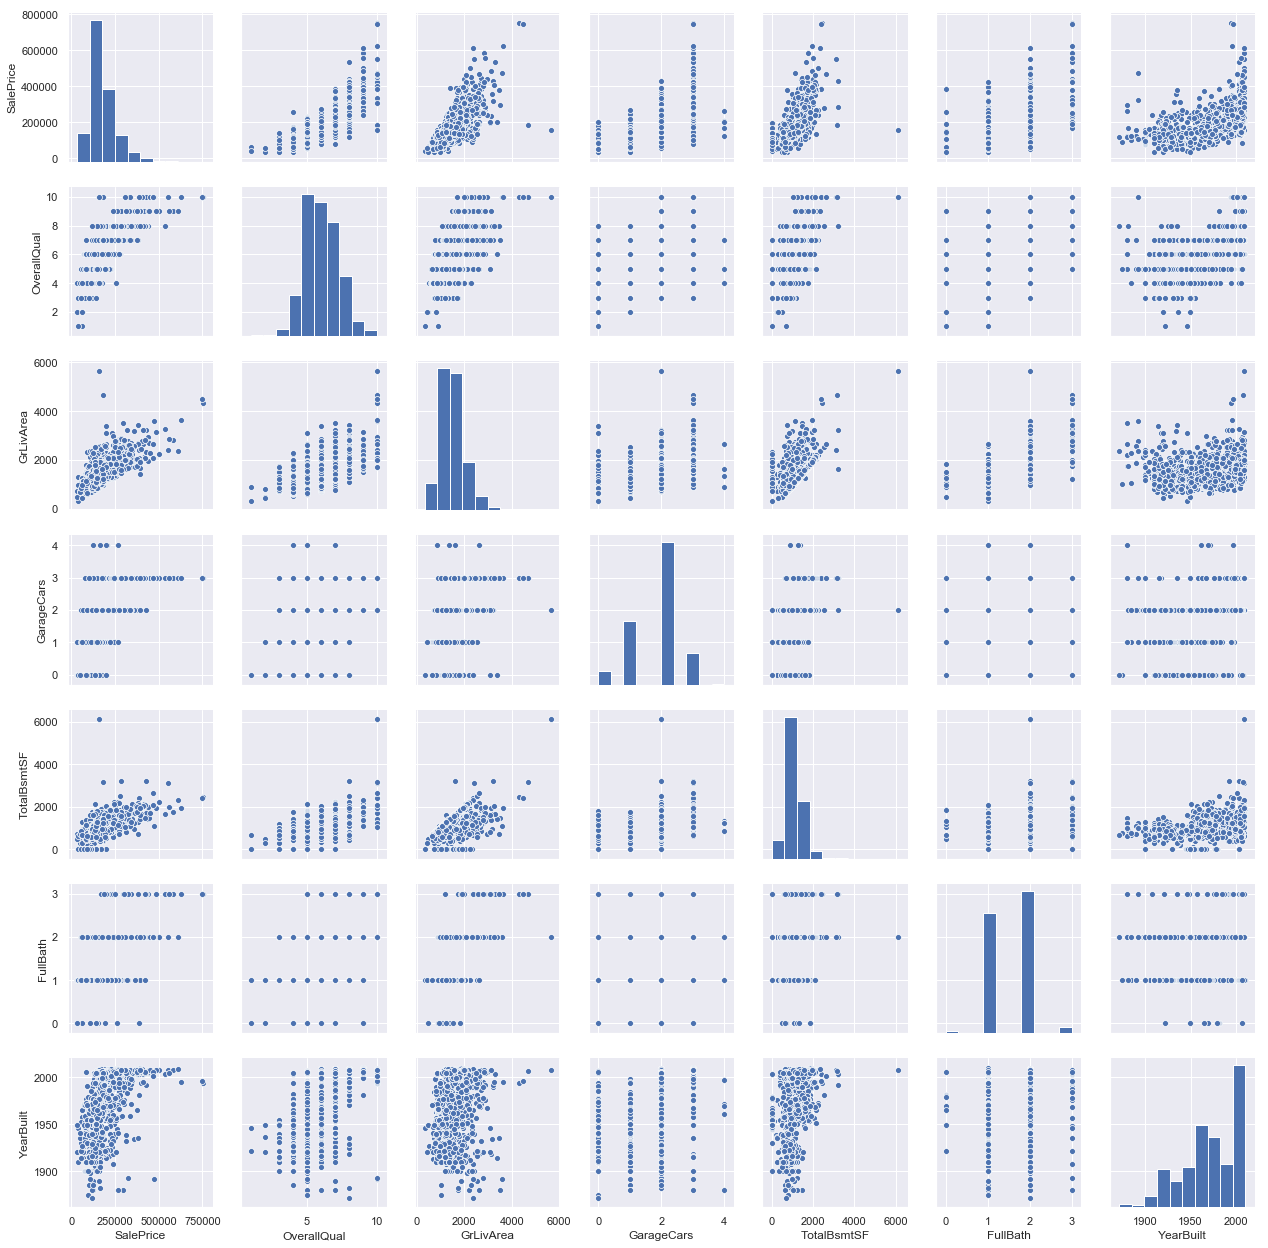

In [11]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show()
# Seaborn plot to visualise the correlation among variables.

###### Check for missing values.

In [12]:
df[cols].isnull().sum()
# No missing values in the selected columns.

SalePrice      0
OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
dtype: int64

In [13]:
df['MasVnrArea'].fillna(0,inplace=True)

#### Outliers

Here for outliers, Standardizing the saleprice variable so that its mean is equal to 0 and standarad deviation is equal to 1. And then deleting the values considered as outliers.
Although, a much better analysis for outliers can done.

In [14]:
scaler=StandardScaler()
df["saleprice_scaled"]=scaler.fit_transform(df['SalePrice'][:,np.newaxis]);

C:\Users\bhardwaj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bhardwaj\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


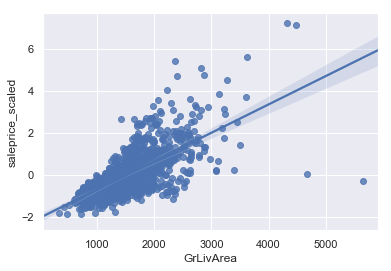

In [15]:
sns.regplot(x="GrLivArea",y="saleprice_scaled",data=df)

There are two values in extreme right which are not following the crowd. These are the values I am considering as outliers and removing them. The two observations at the top are following the crowd therefore I am not considered them as outliers for now.

In [16]:
df.sort_values(by = 'GrLivArea', ascending = False)[:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,saleprice_scaled
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,Gd,NaN,NaN,0,1,2008,New,Partial,160000,-0.263440
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,NaN,NaN,NaN,0,10,2007,New,Partial,184750,0.048212


In [17]:
df = df.drop(1299)
df= df.drop(524)

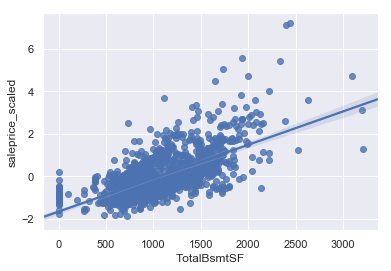

In [18]:
sns.regplot(x="TotalBsmtSF",y="saleprice_scaled",data=df)

Before training  regression model, I am first checking for some of properties to enable multivariate analysis.

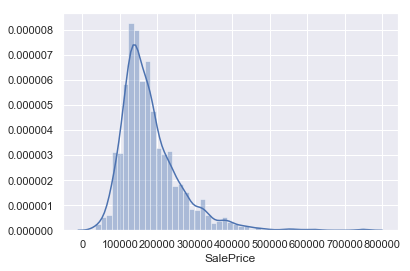

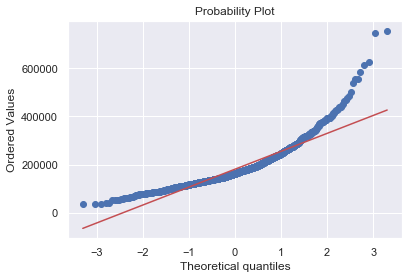

In [19]:
sns.distplot(df['SalePrice']);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

Although SalePrice do not follow normal distribution but log of saleprice does approximately.Similarly for GrlivArea.

In [20]:
df['logsaleprice']=np.log(df['SalePrice'])

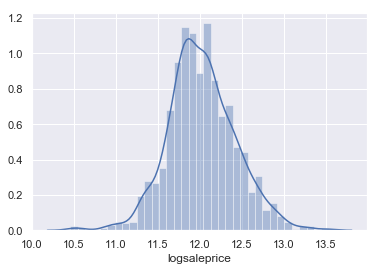

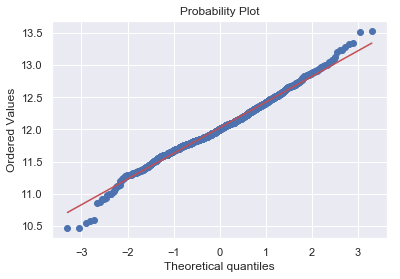

In [21]:
sns.distplot(df['logsaleprice']);
fig = plt.figure()
res = stats.probplot(df['logsaleprice'], plot=plt)

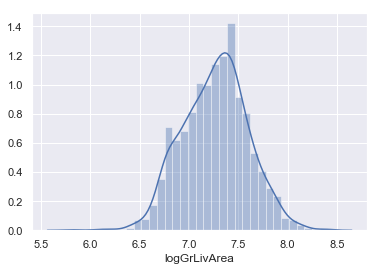

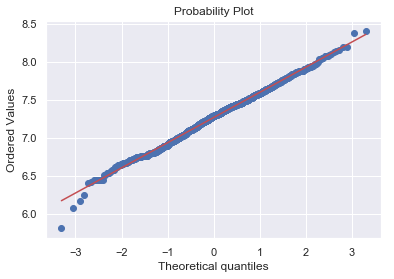

In [22]:
df['logGrLivArea']=np.log(df['GrLivArea'])
sns.distplot(df['logGrLivArea'],norm_hist=True);
fig = plt.figure()
res = stats.probplot(df['logGrLivArea'], plot=plt)

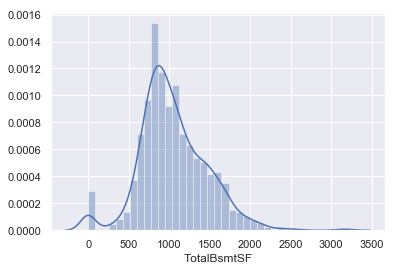

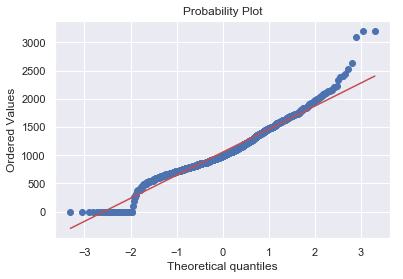

In [23]:
#df['logTotalBsmtSF']=np.log(df['TotalBsmtSF'])
sns.distplot(df['TotalBsmtSF'],norm_hist=True);
fig = plt.figure()
res = stats.probplot(df['TotalBsmtSF'], plot=plt)

Then taking dummies.

In [24]:
FullBath=pd.get_dummies(df['FullBath'])
df=pd.concat((df,FullBath),axis=1)

In [25]:
df.rename(columns={0:'fb0',1:'fb1',2:'fb2', 3:'fb3'}, inplace=True)

In [26]:
df=pd.concat((df,pd.get_dummies(df['GarageCars'])),axis=1)
df.rename(columns={0:'GC0',1:'GC1',2:'GC2', 3:'GC3',4:'GC4'}, inplace=True)

Now comes training of Linear Regression model. 

In [27]:
cols1 = ['OverallQual', 'logGrLivArea','fb0','fb1','fb2','fb3','TotalBsmtSF','FullBath','GC0','GC1','GC2','GC3','GC4','YearBuilt','MasVnrArea']

In [28]:
X=df[cols1]

In [29]:
y=df['logsaleprice']

In [30]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3)

In [31]:
reg = LinearRegression().fit(Xtrain,ytrain)

In [32]:
pred=reg.predict(Xtest)

In [33]:
predictors=Xtrain.columns

In [34]:
coef = Series(reg.coef_,predictors).sort_values()

In [35]:
print(r2_score(ytest,pred))

0.8347921398724106


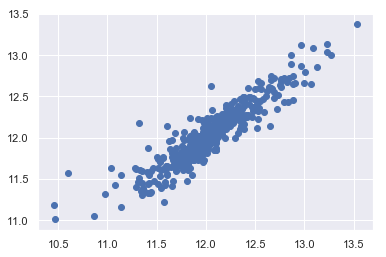

In [36]:
plt.scatter(ytest,pred)

In [37]:
scores = cross_val_score(reg,Xtrain, ytrain, cv=5)
print ("Cross-validated scores:", scores)
print ("Average Cross-validated score:", scores.mean())

Cross-validated scores: [0.84749657 0.79633962 0.84411458 0.85840224 0.87451527]
Average Cross-validated score: 0.844173656633316


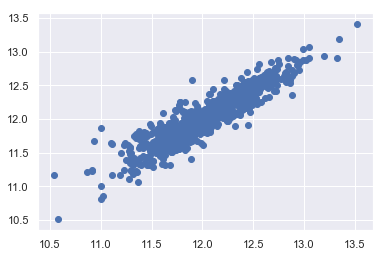

In [38]:
predictions = cross_val_predict(reg, Xtrain, ytrain, cv=5)
plt.scatter(ytrain, predictions)

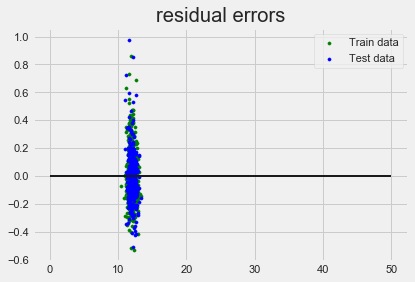

In [39]:
plt.style.use('fivethirtyeight')
plt.scatter(reg.predict(Xtrain),reg.predict(Xtrain)-ytrain,color='green',s=10,label="Train data")
plt.scatter(reg.predict(Xtest),reg.predict(Xtest)-ytest,color='Blue',s=10,label="Test data")
plt.hlines(y=0,xmin=0,xmax=50,linewidth=2)
plt.legend(loc='upper right')
plt.title('residual errors')
plt.show()
## Plot of errors for test and train data.

Here,model accuracy is quite good. And now using Random forest for modelling and will choose the one which performs better.

#### Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [61]:
regr = RandomForestRegressor(n_estimators=20,max_features=4)

In [62]:
cols_RF=['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt','Fireplaces','MasVnrArea']

In [63]:
df[cols_RF].isnull().sum()

OverallQual    0
GrLivArea      0
GarageCars     0
TotalBsmtSF    0
FullBath       0
YearBuilt      0
Fireplaces     0
MasVnrArea     0
dtype: int64

In [64]:
y1=df['SalePrice']

In [65]:
Xtrain1,Xtest1,ytrain1,ytest1=train_test_split(df[cols_RF],y1,test_size=0.3)

In [66]:
regr.fit(Xtrain1,ytrain1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [67]:
rfpred=regr.predict(Xtest1)

In [68]:
r2_score(ytest1,rfpred)

0.8814701102854748

In [69]:
mean_squared_error(ytest1,rfpred)

723354029.9188643

In [70]:
parameters={'max_features':np.arange(1,7),'n_estimators':np.arange(10,31)}

In [71]:
RFR=RandomForestRegressor()

In [72]:
RFR_regressor=GridSearchCV(RFR,parameters,scoring='neg_mean_squared_error',cv=5)

In [73]:
RFR_regressor.fit(Xtrain1,ytrain1)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': array([1, 2, 3, 4, 5, 6]), 'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [74]:
best_param=RFR_regressor.best_params_

In [75]:
RFR_fit=RFR.set_params(**best_param).fit(Xtrain1,ytrain1)

In [76]:
RFRpred=RFR_fit.predict(Xtest1)

In [77]:
r2_score(ytest1,RFRpred)

0.8861516924770074

In [78]:
for name, importance in zip(df[cols1], RFR_fit.feature_importances_):
    print(name, "=", importance)

OverallQual = 0.3828675777983382
logGrLivArea = 0.19147279961769997
fb0 = 0.0960046005742405
fb1 = 0.1613088797716236
fb2 = 0.023938752762699213
fb3 = 0.09977289840769232
TotalBsmtSF = 0.014590704315605768
FullBath = 0.030043786752100416


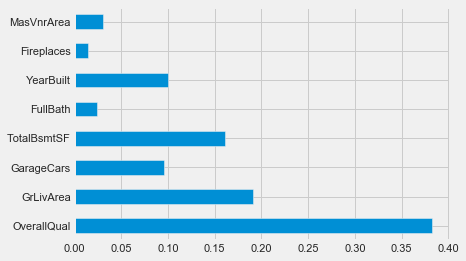

In [79]:
feat_importances = pd.Series(RFR_fit.feature_importances_, index=df[cols_RF].columns)
feat_importances.plot(kind='barh')

Clearly, Random forest performs better than Linear Regression Model.